# Tools & Libraries

In [4]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\stc
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [77]:
from pa_lib.job import request_job
from pa_lib.file import project_dir, load_bin
from pa_lib.data import desc_col
from pa_lib.vis import boxplot_histogram

In [6]:
import pandas as pd
import numpy as np

# Load and Prep

In [234]:
########################################################################################
## Load generated ek_list for VBs:

with project_dir("vkprog/predictions"):
    ek_list = load_bin("20200127_ek_list.feather")

########################################################################################
## Compute Net_Max:
_net_columns_ = [col for col in ek_list.columns if "Net" in col]
_net_max_ = ek_list.loc[:, _net_columns_].fillna(0).max(axis="columns")

ek_list.loc[:, "Net_Max"] = _net_max_

del _net_columns_, _net_max_
########################################################################################
## Create technical Stand-In for HB_APG:

ek_list.loc[:, "_HB_APG_"] = ek_list.HB_APG.fillna("NONE")

########################################################################################
## Rank Net_Max per VB:

_ranking_pro_vb_ = ek_list.groupby("_HB_APG_")["Net_Max"].rank(
    ascending=True, method="dense"
)

ek_list.loc[:, "_ranking_01_"] = _ranking_pro_vb_

del _ranking_pro_vb_
########################################################################################
## Calculate the Max-Rank per VB and add it to ek_list:

ek_list = pd.merge(
    ek_list,
    pd.DataFrame(ek_list.groupby(by="_HB_APG_")["_ranking_01_"].max())
    .reset_index()
    .rename(columns={"_ranking_01_": "_max_rank_"}),
    on="_HB_APG_",
    how="left",
).drop(columns="_HB_APG_")

########################################################################################
## Calculate f_score $\exist in [0,1]:

ek_list.loc[:, "f_score"] = ek_list._ranking_01_ / ek_list._max_rank_

ek_list = ek_list.drop(columns={"_ranking_01_", "_max_rank_"})
########################################################################################
## Calculate prob_KW*f_score $\exist in [0,1]:

ek_list.loc[:, "new_feature_pf"] = ek_list.f_score * ek_list.prob_KW
# ek_list.loc[:, "pf_minus_prob_KW"] = ek_list.new_feature_pf - ek_list.prob_KW

17:45:36 [INFO] Started loading binary file ...
17:45:36 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20200127_ek_list.feather
17:45:36 [INFO] ... finished loading binary file in 0.01s (0.02s CPU)


# Checks

In [235]:
ek_list.columns


Index(['index', 'Endkunde_NR', 'Endkunde', 'HB_APG', 'Agentur', 'HB_Agentur',
       'PLZ', 'Ort', 'Net_2016', 'Net_2017', 'Net_2018', 'Net_2019',
       'Net_2020', 'letzte_VBs', 'Datum_Letzter_Ktkt', 'letzter_Kontakt',
       'Kanal', 'Betreff', 'letzte_Kamp_erfasst', 'letzte_Kamp_Beginn',
       'Verkaufsgebiet', 'VB_VK_Geb', 'prob_KW', 'Insolvenz',
       'last_CRM_Ktkt_date', 'VB_FILTER_VON', 'VB_FILTER_BIS', 'Net_Max',
       'f_score', 'new_feature_pf'],
      dtype='object')

In [237]:
for x in [ek_list.loc[:,["prob_KW",'Net_Max',
       'HB_APG',"f_score",'new_feature_pf']]]:
    
    display(x.sample(3))
    display(desc_col(x))

,prob_KW,Net_Max,HB_APG,f_score,new_feature_pf
5028,0.287904,2178.0,None,0.371212,0.106873
1084,0.443941,3449.0,MWY,0.509554,0.226212
3686,0.323294,3499.0,None,0.484848,0.156749


,DTYPE,NULLS,UNIQUE
prob_KW,float64,0/12703,12608
Net_Max,float64,0/12703,8307
HB_APG,object,286/12417,61
f_score,float64,0/12703,10366
new_feature_pf,float64,0/12703,12701


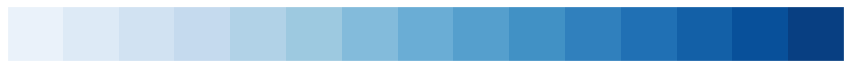

In [232]:
sns.palplot(sns.color_palette(palette='Blues',n_colors=15))